<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/GTVMin_FC_FL_Green_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume (3).csv


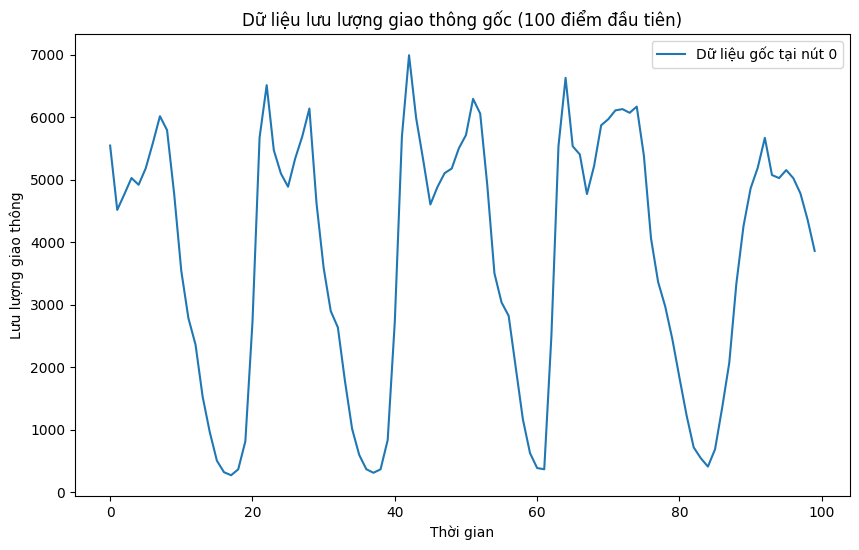

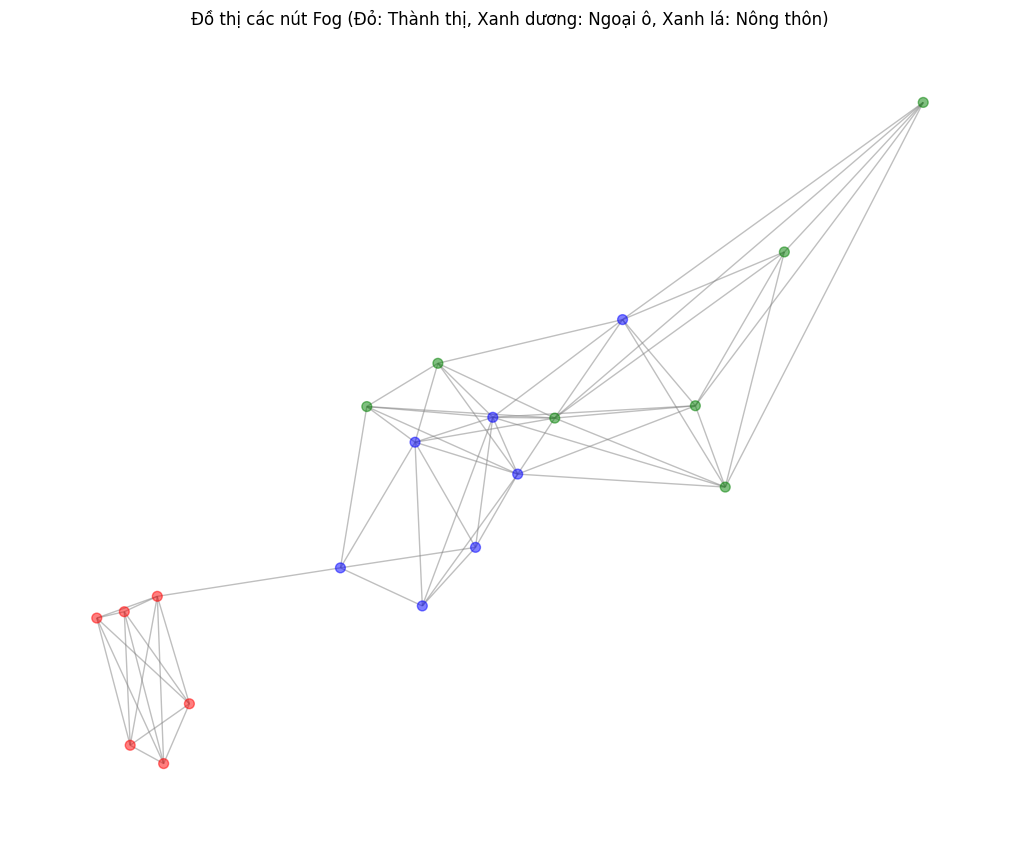

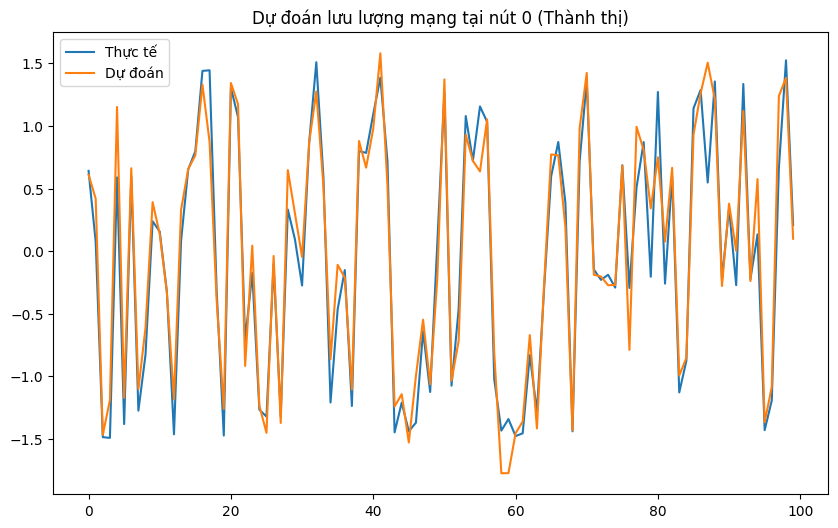

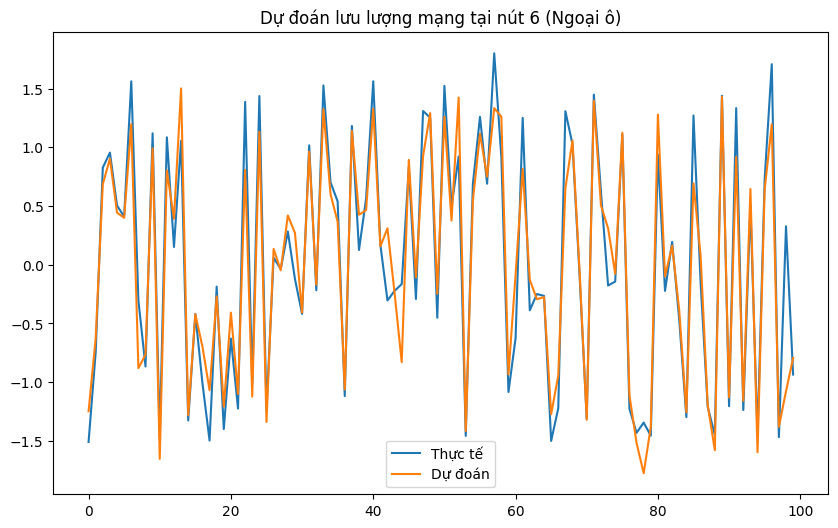

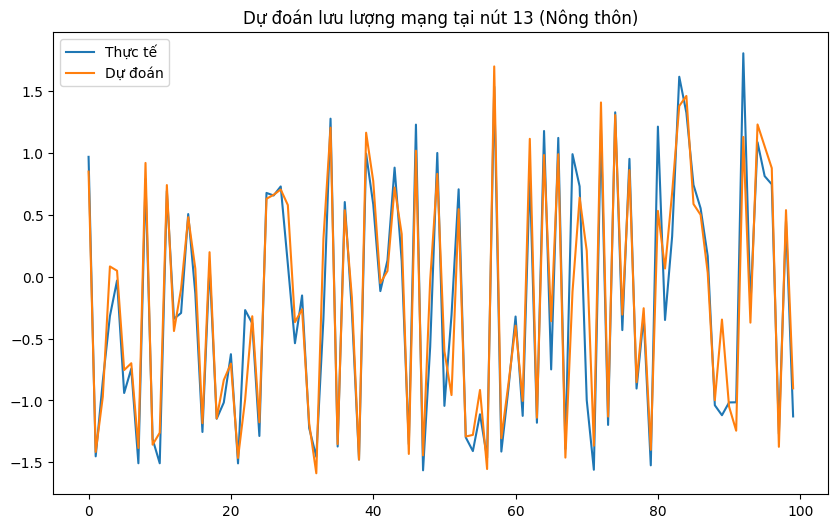

Lỗi trung bình trên tập huấn luyện: 0.0979
Lỗi trung bình trên tập kiểm tra: 0.0939


In [11]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from google.colab import files

# Kích hoạt GPU trên Colab
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ===================== PHẦN 1: TẢI VÀ CHUẨN BỊ DỮ LIỆU =====================

uploaded = files.upload()
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

data = data[['date_time', 'traffic_volume']]
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.sort_values('date_time')

# Kiểm tra dữ liệu gốc tại nút 0
plt.figure(figsize=(10, 6))
plt.plot(data['traffic_volume'][:100], label='Dữ liệu gốc tại nút 0')
plt.title("Dữ liệu lưu lượng giao thông gốc (100 điểm đầu tiên)")
plt.xlabel("Thời gian")
plt.ylabel("Lưu lượng giao thông")
plt.legend()
plt.show()

num_nodes = 20
urban_nodes = 6
suburban_nodes = 7
rural_nodes = 7

data_per_node = np.array_split(data['traffic_volume'].values, num_nodes)

coords = np.zeros((num_nodes, 2))
coords[:urban_nodes] = np.random.normal(loc=[50, 50], scale=5, size=(urban_nodes, 2))
coords[urban_nodes:urban_nodes + suburban_nodes] = np.random.normal(loc=[70, 70], scale=10, size=(suburban_nodes, 2))
coords[urban_nodes + suburban_nodes:] = np.random.normal(loc=[90, 90], scale=15, size=(rural_nodes, 2))

def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

normalized_data = []
means, stds = [], []
for d in data_per_node:
    norm_d, m, s = normalize(d)
    normalized_data.append(norm_d)
    means.append(m)
    stds.append(s)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_nodes, y_nodes = [], []
for d in normalized_data:
    X, y = create_sequences(d, seq_length)
    X_nodes.append(X)
    y_nodes.append(y)

# ===================== PHẦN 2: XÂY DỰNG ĐỒ THỊ THỰC NGHIỆM =====================

def plot_fog_graph(G, coords):
    plt.figure(figsize=(10, 8))
    pos = {i: coords[i] for i in range(len(coords))}
    nx.draw(G, pos, node_color=['red']*urban_nodes + ['blue']*suburban_nodes + ['green']*rural_nodes,
            node_size=50, with_labels=False, edge_color='gray', alpha=0.5)
    plt.title("Đồ thị các nút Fog (Đỏ: Thành thị, Xanh dương: Ngoại ô, Xanh lá: Nông thôn)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

G_fog = nx.Graph()
G_fog.add_nodes_from(range(num_nodes))
A = kneighbors_graph(coords, n_neighbors=5, mode='distance').toarray()
for i in range(num_nodes):
    for j in range(num_nodes):
        if A[i, j] > 0:
            G_fog.add_edge(i, j, weight=np.exp(-A[i, j]**2 / (2 * 10**2)))

plot_fog_graph(G_fog, coords)

for i in range(num_nodes):
    X_train, X_val, y_train, y_val = train_test_split(X_nodes[i], y_nodes[i], test_size=0.2, random_state=42)
    G_fog.nodes[i]['X_train'] = X_train
    G_fog.nodes[i]['y_train'] = y_train
    G_fog.nodes[i]['X_val'] = X_val
    G_fog.nodes[i]['y_val'] = y_val
    G_fog.nodes[i]['coord'] = coords[i]

# ===================== PHẦN 3: ĐỊNH NGHĨA MÔ HÌNH LSTM =====================

def build_lstm_model(seq_length):
    model = Sequential([
        Input(shape=(seq_length, 1)),
        LSTM(32, kernel_regularizer=l2(0.01)),  # Giảm số units, thêm L2 regularization
        Dropout(0.2),  # Thêm Dropout để giảm overfitting
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

models = {i: build_lstm_model(seq_length) for i in range(num_nodes)}

# ===================== PHẦN 4: HUẤN LUYỆN VỚI GTVMin VÀ MESSAGE PASSING =====================

max_iter = 20
eta = 0.01
alpha = 0.1  # Giảm alpha để giảm regularization

def compute_gtvmin_gradient(model, neighbors, weights, alpha):
    reg_grad = [np.zeros_like(w) for w in model.get_weights()]
    for j in neighbors:
        A_ij = G_fog[i][j]['weight']
        w_j = weights[j]
        for layer in range(len(reg_grad)):
            reg_grad[layer] += 2 * alpha * A_ij * (model.get_weights()[layer] - w_j[layer])
    return reg_grad

for iteration in range(max_iter):
    weights = {i: models[i].get_weights() for i in range(num_nodes)}

    for i in range(num_nodes):
        X_train = G_fog.nodes[i]['X_train']
        y_train = G_fog.nodes[i]['y_train']

        # Tăng số epochs cục bộ để học tốt hơn
        models[i].fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)

        neighbors = list(G_fog.neighbors(i))
        reg_grad = compute_gtvmin_gradient(models[i], neighbors, weights, alpha)

        new_weights = [w - eta * g for w, g in zip(models[i].get_weights(), reg_grad)]
        models[i].set_weights(new_weights)

    # Chỉ thực hiện Message Passing sau mỗi 2 vòng lặp
    if iteration % 2 == 0:
        for i in range(num_nodes):
            neighbors = list(G_fog.neighbors(i))
            avg_weights = [weights[i]]
            total_weight = 1.0
            for j in neighbors:
                A_ij = G_fog[i][j]['weight']
                avg_weights.append([A_ij * w for w in weights[j]])
                total_weight += A_ij
            new_weights = []
            for layer in range(len(weights[i])):
                layer_avg = np.sum([w[layer] for w in avg_weights], axis=0) / total_weight
                new_weights.append(layer_avg)
            models[i].set_weights(new_weights)

# ===================== PHẦN 5: ĐÁNH GIÁ KẾT QUẢ =====================

train_errors, val_errors = [], []
for i in range(num_nodes):
    X_train = G_fog.nodes[i]['X_train']
    y_train = G_fog.nodes[i]['y_train']
    X_val = G_fog.nodes[i]['X_val']
    y_val = G_fog.nodes[i]['y_val']

    train_pred = models[i].predict(X_train, verbose=0)
    val_pred = models[i].predict(X_val, verbose=0)

    train_errors.append(mean_squared_error(y_train, train_pred))
    val_errors.append(mean_squared_error(y_val, val_pred))

    # Điều chỉnh chỉ số nút để phù hợp với num_nodes = 20
    if i in [0, 6, 13]:
        plt.figure(figsize=(10, 6))
        plt.plot(y_val[:100], label='Thực tế')
        plt.plot(val_pred[:100], label='Dự đoán')
        plt.legend()
        plt.title(f"Dự đoán lưu lượng mạng tại nút {i} ({'Thành thị' if i < 6 else 'Ngoại ô' if i < 13 else 'Nông thôn'})")
        plt.show()

print(f"Lỗi trung bình trên tập huấn luyện: {np.mean(train_errors):.4f}")
print(f"Lỗi trung bình trên tập kiểm tra: {np.mean(val_errors):.4f}")